In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler

W1009 20:24:07.369071 19812 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1009 20:24:07.401056 19812 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
no_cuda = False
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 5
image_size = (224,224)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([            
    transforms.Resize(256),                    
    transforms.CenterCrop(224),                
    transforms.ToTensor(),                     
    transforms.Normalize(                     
        mean=[0.485, 0.456, 0.406],               
        std=[0.229, 0.224, 0.225]                  
    )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign',
                             transform=data_transform)

# split into train and test dataset
train_split = 0.8
dataset_size = 2000 #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(train_indices),
                                              **kwargs)

test_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(test_indices),
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign_backdoors',
                             transform=data_transform)

# shorten for testing reasons
size = len(backdoored) #for testing purpose set to 1000 - else set: len(backdoored) 
indices = list(range(len(backdoored)))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
usedIndices = indices[:size]

backdoored.classes = '001' #<-- set all backdoors to a specific (wrong) class

dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(usedIndices),
                                              **kwargs)

# Visualize some training data

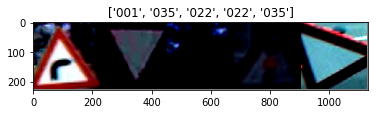

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(4096,2048)            #First Fully-Connected Layer
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, len(class_names))


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 4096)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
##backdoored clients   
#for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
#            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
#            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
#            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

# Training Function

In [9]:
def train(epoch):
    #backdoor training in the beginning
#    for batch_idx, (data,target) in enumerate(train_distributed_dataset_backdoor):        
#        model.send(data.location) # 0) send the model to the right location
#        data, target = data.to(device), target.to(device)
#        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
#        #import pdb; pdb.set_trace()
#        output = model(data)  # 2) make a prediction
#        loss = F.nll_loss(output, target) # 3) calculate how much we missed
#        loss.backward() # 4) figure out which weights caused us to miss
#        optimizer.step() # 5) change those weights
#        model.get() # 6) get model (with gradients)
#            
#        #if batch_idx % 100 == 0:
#        loss = loss.get() # <-- NEW: get the loss back
#        print('BACKDOOR: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * batch_size, len(train_distributed_dataset_backdoor) * batch_size,
#                100. * batch_idx / len(train_distributed_dataset_backdoor), loss.item()))
    
    #normal training
    for batch_idx, (data,target) in enumerate(train_distributed_dataset):        
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        #loss = F.nll_loss(output, target) # 3) calculate how much we missed
        loss = nn.CrossEntropyLoss(output, target)
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 100 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset) * batch_size,
                100. * batch_idx / len(train_distributed_dataset), loss.item()))

# Test Function

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Set pretrained model

In [30]:
#model = Net().to(device)

#download vgg16
model = models.vgg11(pretrained=True)

# Freeze parameters so we don't backprop through them
#for param in model.parameters():
#    param.requires_grad = False
#
num_ftrs = model.classifier._modules['6'].in_features
model.classifier._modules['6'] = nn.Linear(num_ftrs, 10)


#model.fc = nn.Sequential(
#    nn.Linear(4096, 256),
#    nn.ReLU(),
#    nn.Dropout(0.4),
#    nn.Linear(256, 10), 
#    nn.LogSoftmax(dim=1) # For using NLLLoss()
#)


##criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier._modules['6'].parameters(), lr=0.001)
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
##criterion = nn.CrossEntropyLoss()
#
#num_ftrs = model.classifier._modules['6'].in_features
#model.classifier._modules['6'] = nn.Linear(num_ftrs, 10)
#
#model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

# Run everyting

In [32]:
# stopped at:
#model.load_state_dict(torch.load("gtsdb_paper_2.pt"))

#RUN training
for epoch in range(1, 50):
    #scheduler.step()
    train(epoch)
    #torch.save(model.state_dict(), ("gtsdb_paper_" + str(epoch) + ".pt"))
    test(model, device, test_loader)
    

#save model


RuntimeError: weight should have at least three dimensions

In [ ]:
torch.save(model.state_dict(), ("trafficsign_without_backdoor_" + str(50) + ".pt"))

In [ ]:
torch.cuda.is_available()